In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import GlobalMaxPool1D,Embedding,Dense
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
#from bs4 import BeautifulSoup
import plotly.graph_objs as go
from keras.models import Sequential
from keras import layers
import tensorflow as tf 

In [3]:
df = pd.read_csv("../input/new-cleaned-data/cleaned_data.csv")

In [5]:
df = df[["text_eng_cleaned","label"]]
df.rename(columns={"text_eng_cleaned": "text"},inplace = True)

In [6]:
df.dropna(inplace = True)

In [7]:
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    
    text = re.sub(pattern, '', x)
    text = re.sub(r'[^\w\s]', '', text)
    return text

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]**{4}**', '####', x)
        x = re.sub('[0-9]**{3}**', '###', x)
        x = re.sub('[0-9]**{2}**', '##', x)
    return x


In [9]:
cleaned_text = []
for i in df["text"]:
    i = clean_text(i)
    #i = clean_numbers(i)
    cleaned_text.append(i)

In [10]:
df["text"]=cleaned_text

In [111]:
X_train,X_test,y_train,y_test = train_test_split(df["text"],df["label"],test_size = 0.2,random_state = 43)

In [112]:
from sklearn import preprocessing
def prepare_targets(y_train, y_test):
    le = preprocessing.LabelEncoder()

    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [113]:
y_train_enc,y_test_enc = prepare_targets(y_train,y_test)

In [114]:
y_train_enc = tf.one_hot(y_train_enc, 6) 
y_test_enc = tf.one_hot(y_test_enc, 6) 

In [115]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [116]:
X_train = tokenizer.texts_to_sequences(X_train,)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [117]:
print(X_train[10])

[21756, 10, 666, 193, 2881, 10, 458, 61, 6, 2, 766, 124, 4575, 1253, 999, 33, 576, 291, 999, 4, 346, 33, 234, 379, 3011, 15, 119, 2, 1918, 4, 674, 241, 2, 451, 39, 90, 4, 2, 2526, 206, 3, 907, 4, 2732, 1415, 11, 79, 11489, 6392, 4, 27, 7, 2334, 404, 2, 218, 33, 1283, 14, 20, 39, 90, 3802, 4, 277, 2638, 207, 5, 2, 124, 16, 5950, 4575, 383, 907, 2638, 8, 4210, 27528, 4, 3185, 294, 76941, 9089, 76942, 12580, 336, 1638, 336, 4978, 336, 21757, 999, 22952, 336, 1638]


In [118]:
maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen,truncating="post")
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen,truncating="post")

In [119]:

vocab_size

142960

In [20]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    file = open(filepath, errors = 'ignore', encoding='utf8')
    for line in file:
        word, *vector = line.split()
        if word in word_index:
            idx = word_index[word] 
            embedding_matrix[idx] = np.asarray(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [122]:
import itertools

embedding_matrix = create_embedding_matrix(r'../input/glove6b/glove.6B.300d.txt',tokenizer.word_index, 300)


In [123]:
embedding_matrix.shape

(142960, 300)

In [124]:

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.38567431449356465

In [125]:
def model(embedding_dimension,pretrained_weights,num_classes,lr,maxlen):
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model = Sequential()
    model.add(Embedding(vocab_size,embedding_dimension,weights = [pretrained_weights],
                       input_length = maxlen,trainable = True))
    
    model.add(GlobalMaxPool1D())
    
    model.add(Dense(32,activation = 'relu'))
    model.add(Dense(16,activation = 'relu'))
    
    model.add(Dense(num_classes,activation = "softmax"))
    
    model.summary()
    
    model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
    
    return model

In [126]:
model_save_path = './'

callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
           tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,verbose=0,mode="min",restore_best_weights=True)]

In [33]:
model_standard = model(50,embedding_matrix,6,0.005,maxlen = maxlen)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 50)           7148000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 102       
Total params: 7,150,262
Trainable params: 7,150,262
Non-trainable params: 0
_________________________________________________________________


In [34]:
history_standard=model_standard.fit(X_train,y_train_enc,batch_size=128,epochs=50 ,validation_data=(X_test,y_test_enc),callbacks=callbacks)

Epoch 1/50
186/186 [==============================] - 18s 96ms/step - loss: 1.5601 - accuracy: 0.3559 - val_loss: 1.1872 - val_accuracy: 0.5323
Epoch 2/50
186/186 [==============================] - 17s 94ms/step - loss: 1.0437 - accuracy: 0.5943 - val_loss: 0.9473 - val_accuracy: 0.6411
Epoch 3/50
186/186 [==============================] - 18s 97ms/step - loss: 0.7849 - accuracy: 0.7102 - val_loss: 0.8874 - val_accuracy: 0.6792
Epoch 4/50
186/186 [==============================] - 17s 90ms/step - loss: 0.6242 - accuracy: 0.7778 - val_loss: 0.8676 - val_accuracy: 0.7015
Epoch 5/50
186/186 [==============================] - 17s 91ms/step - loss: 0.5452 - accuracy: 0.8092 - val_loss: 0.9069 - val_accuracy: 0.7021
Epoch 6/50
186/186 [==============================] - 16s 88ms/step - loss: 0.4737 - accuracy: 0.8334 - val_loss: 0.9009 - val_accuracy: 0.7143
Epoch 7/50
186/186 [==============================] - 17s 91ms/step - loss: 0.4082 - accuracy: 0.8580 - val_loss: 0.9731 - val_accuracy:

In [35]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

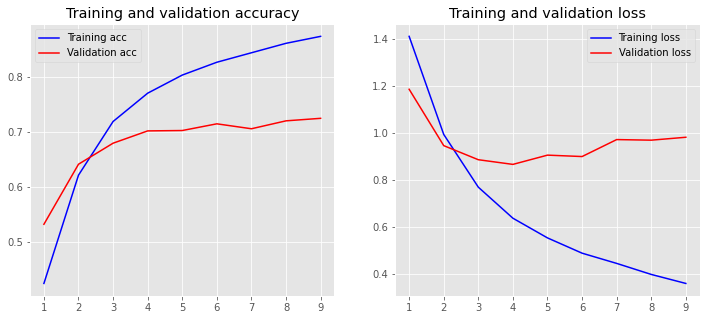

In [36]:
plot_history(history_standard)

In [ ]:
model_standard.evaluate(X_test,y_test_enc)[1]

In [128]:
model = Sequential()
model.add(layers.Embedding(vocab_size, 300,weights = [embedding_matrix],
                           input_length=maxlen,trainable = True))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.Dropout(0.25))

#model.add(layers.GlobalMaxPooling1D())
#model.add(layers.Conv1D(32, (3,), activation='relu'))
#model.add(layers.GlobalMaxPooling1D())
#model.add(layers.Conv1D(64, (3,), activation='relu'))
model.add(layers.GlobalMaxPooling1D())


model.add(layers.Dense(32, activation='relu'))

#model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 300, 300)          42888000  
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 296, 64)           96064     
_________________________________________________________________
dropout_45 (Dropout)         (None, 296, 64)           0         
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_38 (Dense)             (None, 6)                 198       
Total params: 42,986,342
Trainable params: 42,986,342
Non-trainable params: 0
_________________________________________

In [ ]:
history_cnn=model.fit(X_train,y_train_enc,batch_size=128,epochs=100 ,validation_data=(X_test,y_test_enc),callbacks=callbacks)

Epoch 1/100
186/186 [==============================] - 148s 787ms/step - loss: 1.4135 - accuracy: 0.4630 - val_loss: 0.8379 - val_accuracy: 0.7118
Epoch 2/100
  5/186 [..............................] - ETA: 2:16 - loss: 0.6939 - accuracy: 0.7603

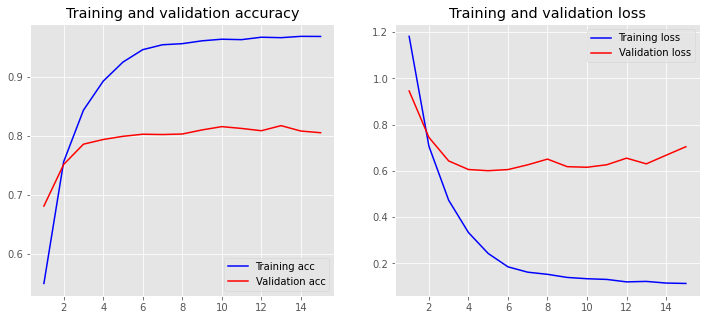

In [109]:
plot_history(history_cnn)

In [110]:
model.evaluate(X_test,y_test_enc)[1]

186/186 [==============================] - 1s 5ms/step - loss: 0.6010 - accuracy: 0.7991


0.7991229295730591

In [102]:
model_lstm = Sequential()
model_lstm.add(layers.Embedding(vocab_size, 50,weights = [embedding_matrix],
                           input_length=maxlen,trainable = False))
model_lstm.add(Dropout(rate=0.25))
model_lstm.add(layers.Conv1D(64, 5, activation='relu'))


model_lstm.add(layers.MaxPooling1D())
#model.add(layers.Conv1D(32, (3,), activation='relu'))
#model.add(layers.GlobalMaxPooling1D())
#model.add(layers.Conv1D(64, (3,), activation='relu'))
#model_lstm.add(layers.GlobalMaxPooling1D())
model_lstm.add(Dropout(rate=0.25))


model_lstm.add(LSTM(64,return_sequences=False, dropout=0.2, recurrent_dropout=0.15))
#model_lstm.add(layers.GlobalMaxPooling1D())

model_lstm.add(Dropout(rate=0.25))
#model_lstm.add(keras.layers.Flatten())

model_lstm.add(Dense(16, activation='relu'))

#model.add(Dense(32,activation = 'relu'))
model_lstm.add(Dense(6, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#epochs = 5
batch_size = 128

model_lstm.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, 250, 50)           7148000   
_________________________________________________________________
dropout_41 (Dropout)         (None, 250, 50)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 246, 64)           16064     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 123, 64)           0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 123, 64)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)              

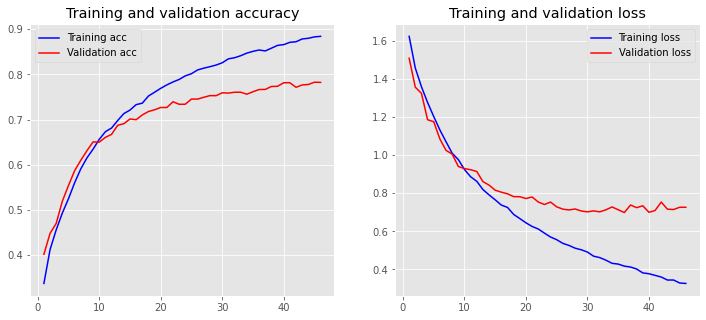

In [45]:
plot_history(history_lstm)

In [46]:
model_lstm.evaluate(X_test,y_test_enc)[1]

186/186 [==============================] - 27s 146ms/step - loss: 0.6986 - accuracy: 0.7666


0.7665711045265198